<a href="https://colab.research.google.com/github/SeungHwaJung/Auto-Mobile-/blob/main/0709_python_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. 기본 MOG2 차량 감지 코드
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


# 동영상 파일 열기 (코랩에서는 업로드한 파일 경로 사용)
cap = cv2.VideoCapture('/주행 영상.mp4')  # 파일 경로 수정 필요


# MOG2 배경 차분기 생성
backSub = cv2.createBackgroundSubtractorMOG2()


frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 배경 차분 적용
    fgMask = backSub.apply(frame)

    # 매 20프레임마다 결과 출력 (너무 많은 출력 방지)
    if frame_count % 20 == 0:   # 30초마다 1프레임
        # 결과를 나란히 표시
        combined = np.hstack((frame, cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR)))
        cv2_imshow(combined)

    frame_count += 1

    # 100프레임 정도만 처리 (테스트용)
    if frame_count > 100:
        break


# 자원 해제
cap.release()
print("처리 완료!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Noise제거 추가

In [ ]:
# 1. 기본 MOG2 차량 감지 코드
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


# 동영상 파일 열기 (코랩에서는 업로드한 파일 경로 사용)
cap = cv2.VideoCapture('/주행 영상.mp4')  # 파일 경로 수정 필요


# MOG2 배경 차분기 생성
backSub = cv2.createBackgroundSubtractorMOG2()


frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 배경 차분 적용
    fgMask = backSub.apply(frame)

     # 노이즈 제거 (모폴로지 연산)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel)  # 작은 노이즈 제거
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_CLOSE, kernel)  # 구멍 메우기

    # 매 20프레임마다 결과 출력 (너무 많은 출력 방지)
    if frame_count % 20 == 0:   # 30초마다 1프레임
        # 결과를 나란히 표시
        combined = np.hstack((frame, cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR)))
        cv2_imshow(combined)

    frame_count += 1

    # 100프레임 정도만 처리 (테스트용)
    if frame_count > 100:
        break


# 자원 해제
cap.release()
print("처리 완료!")

윤곽선 검출 및 바운딩 박스

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# 동영상 파일 열기 (코랩에서는 업로드한 파일 경로 사용)
cap = cv2.VideoCapture('/주행 영상.mp4')  # 파일 경로 수정 필요

# MOG2 배경 차분기 생성
backSub = cv2.createBackgroundSubtractorMOG2()

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 배경 차분 적용
    fgMask = backSub.apply(frame)

    # 노이즈 제거 (모폴로지 연산)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel)  # 작은 노이즈 제거
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_CLOSE, kernel)  # 구멍 메우기

    # 윤곽선 검출 및 바운딩 박스
    contours, _ = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 바운딩 박스를 그릴 프레임 복사
    result_frame = frame.copy()

    for contour in contours:
        # 너무 작은 영역은 제외 (차량이 아닐 가능성 높음)
        if cv2.contourArea(contour) > 1000:
            x, y, w, h = cv2.boundingRect(contour)

            # 종횡비 필터 추가 (차량은 보통 가로가 세로보다 길거나 비슷함)
            aspect_ratio = w / h
            if 0.5 <= aspect_ratio <= 4.0:  # 너무 세로로 길거나 가로로 긴 것 제외
                cv2.rectangle(result_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # 매 20프레임마다 결과 출력 (너무 많은 출력 방지)
    if frame_count % 20 == 0:   # 20프레임마다 1번 출력
        combined = np.hstack((frame, cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR)))
        cv2_imshow(combined)

    frame_count += 1

    # 100프레임 정도만 처리 (테스트용)
    if frame_count > 100:
        break

# 자원 해제
cap.release()
print("처리 완료!")

ROI 마스크 생성 및 적용 추가

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 동영상 파일 열기
cap = cv2.VideoCapture('/주행 영상.mp4')  # 경로를 정확히 설정하세요

# MOG2 배경 차분기 생성
backSub = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=25, detectShadows=True)

# ROI 설정 함수
def create_roi_mask(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    # 도로 영역 설정 (필요시 조정)
    roi_points = np.array([
        [0, height//2],
        [width, height//2],
        [width, height],
        [0, height]
    ], np.int32)

    cv2.fillPoly(mask, [roi_points], 255)
    return mask

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 배경 차분
    fgMask = backSub.apply(frame)

    # ROI 마스크 적용
    roi_mask = create_roi_mask(frame)
    fgMask = cv2.bitwise_and(fgMask, roi_mask)

    # 노이즈 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel)
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_CLOSE, kernel)

    # 윤곽선 검출
    contours, _ = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result_frame = frame.copy()

    for contour in contours:
        if cv2.contourArea(contour) > 500:  # 임계값 낮춤
            x, y, w, h = cv2.boundingRect(contour)

            # 종횡비 필터 (비활성화하거나 조정 가능)
            aspect_ratio = w / h
            if 0.3 <= aspect_ratio <= 4.5:
                cv2.rectangle(result_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # 결과 출력 (20프레임마다)
    if frame_count % 20 == 0:
        combined = np.hstack((
            cv2.resize(frame, (frame.shape[1]//2, frame.shape[0]//2)),
            cv2.resize(cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR), (frame.shape[1]//2, frame.shape[0]//2)),
            cv2.resize(result_frame, (frame.shape[1]//2, frame.shape[0]//2))
        ))
        cv2_imshow(combined)

    frame_count += 1
    if frame_count > 100:
        break

cap.release()
print("처리 완료!")

또 다른 코드

In [16]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# 동영상 파일 열기 (코랩에서는 업로드한 파일 경로 사용)
cap = cv2.VideoCapture('/content/sample_data/around5.mp4')  # 파일 경로 수정 필요

# MOG2 배경 차분기 생성
backSub = cv2.createBackgroundSubtractorMOG2()

# ROI 설정 (도로 영역만 분석) - 좌표는 영상에 맞게 조정 필요
def create_roi_mask(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    # 도로 영역을 다각형으로 설정 (예시 - 실제 영상에 맞게 조정)
    roi_points = np.array([
        [0, height//2],           # 왼쪽 중간
        [width, height//2],       # 오른쪽 중간
        [width, height],          # 오른쪽 아래
        [0, height]               # 왼쪽 아래
    ], np.int32)

    cv2.fillPoly(mask, [roi_points], 255)
    return mask

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 배경 차분 적용
    fgMask = backSub.apply(frame)

    # ROI 마스크 생성 및 적용
    roi_mask = create_roi_mask(frame)
    fgMask = cv2.bitwise_and(fgMask, roi_mask)  # ROI 영역만 남김

    # 노이즈 제거 (모폴로지 연산)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel)  # 작은 노이즈 제거
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_CLOSE, kernel)  # 구멍 메우기

    # 윤곽선 검출 및 바운딩 박스
    contours, _ = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 바운딩 박스를 그릴 프레임 복사
    result_frame = frame.copy()

    for contour in contours:
        # 너무 작은 영역은 제외 (차량이 아닐 가능성 높음)
        if cv2.contourArea(contour) > 2000:
            x, y, w, h = cv2.boundingRect(contour)

            # 종횡비 필터 추가 (차량은 보통 가로가 세로보다 길거나 비슷함)
            aspect_ratio = w / h
            if 0.5 <= aspect_ratio <= 4.0:  # 너무 세로로 길거나 가로로 긴 것 제외
                cv2.rectangle(result_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # 매 30프레임마다 결과 출력 (너무 많은 출력 방지)
    if frame_count % 10 == 0:
        # 결과를 나란히 표시 (바운딩 박스가 있는 프레임 + 마스크)
        combined = np.hstack((result_frame, cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR)))
        cv2_imshow(combined)

    frame_count += 1

    # 100프레임 정도만 처리 (테스트용)
    if frame_count > 100:
        break

사다리꼴 추가

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 동영상 파일 열기
cap = cv2.VideoCapture('/주행 영상.mp4')  # 파일 경로 수정 필요

# 차선 검출을 위한 ROI 설정
def create_lane_roi(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    # 사다리꼴 모양의 ROI (차선이 있는 도로 영역)
    roi_points = np.array([
        [width//4, height],        # 왼쪽 아래
        [width*3//8, height//2],   # 왼쪽 위
        [width*5//8, height//2],   # 오른쪽 위
        [width*3//4, height]       # 오른쪽 아래
    ], np.int32)

    cv2.fillPoly(mask, [roi_points], 255)
    return mask

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 그레이스케일 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 가우시안 블러로 노이즈 제거
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Canny 에지 검출
    edges = cv2.Canny(blur, 50, 150)

    # ROI 적용
    roi_mask = create_lane_roi(frame)
    masked_edges = cv2.bitwise_and(edges, roi_mask)

    # 결과 프레임 복사
    result_frame = frame.copy()

    # ROI 영역을 시각화 (사다리꼴 모양 표시)
    roi_points = np.array([
        [frame.shape[1]//4, frame.shape[0]],        # 왼쪽 아래
        [frame.shape[1]*3//8, frame.shape[0]//2],   # 왼쪽 위
        [frame.shape[1]*5//8, frame.shape[0]//2],   # 오른쪽 위
        [frame.shape[1]*3//4, frame.shape[0]]       # 오른쪽 아래
    ], np.int32)
    cv2.polylines(result_frame, [roi_points], True, (255, 0, 0), 2)  # 파란색 사다리꼴

    # 매 30프레임마다 결과 출력
    if frame_count % 30 == 0:
        # 영어 라벨 추가
        cv2.putText(result_frame, "Original + ROI", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        edge_display = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)
        cv2.putText(edge_display, "Canny Edge Detection", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # 결과를 나란히 표시 (원본+ROI + 에지검출)
        combined = np.hstack((result_frame, edge_display))
        cv2_imshow(combined)

    frame_count += 1

    # 100프레임 후 종료 (테스트용)
    if frame_count > 100:
        break

# 자원 해제
cap.release()
print("차선 검출 처리 완료!")

차선에 맞게

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 동영상 파일 열기
cap = cv2.VideoCapture('/주행 영상.mp4')  # Colab에 업로드한 파일 경로 사용

# 차선 검출을 위한 ROI 설정 (오른쪽으로 살짝 이동)
def create_lane_roi(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    # 오른쪽으로 약간 이동된 사다리꼴 ROI
    roi_points = np.array([
        [int(width * 2.5/7), height],             # 왼쪽 아래 (기존보다 오른쪽으로 0.5/7 이동)
        [int(width * 3.5/7), int(height * 6/10)], # 왼쪽 위
        [int(width * 4.5/7), int(height * 6/10)], # 오른쪽 위
        [int(width * 5.5/7), height]              # 오른쪽 아래
    ], np.int32)

    cv2.fillPoly(mask, [roi_points], 255)
    return mask

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 그레이스케일 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 가우시안 블러로 노이즈 제거
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Canny 에지 검출
    edges = cv2.Canny(blur, 50, 150)

    # ROI 적용
    roi_mask = create_lane_roi(frame)
    masked_edges = cv2.bitwise_and(edges, roi_mask)

    # 결과 프레임 복사
    result_frame = frame.copy()

    # 시각화용 사다리꼴 (같은 좌표 사용)
    roi_points = np.array([
        [int(frame.shape[1] * 2.5/7), frame.shape[0]],
        [int(frame.shape[1] * 3.5/7), int(frame.shape[0] * 6/10)],
        [int(frame.shape[1] * 4.5/7), int(frame.shape[0] * 6/10)],
        [int(frame.shape[1] * 5.5/7), frame.shape[0]]
    ], np.int32)
    cv2.polylines(result_frame, [roi_points], True, (255, 0, 0), 2)

    # 매 30프레임마다 결과 출력
    if frame_count % 30 == 0:
        cv2.putText(result_frame, "Original + ROI", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        edge_display = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)
        cv2.putText(edge_display, "Canny Edge Detection", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        combined = np.hstack((result_frame, edge_display))
        cv2_imshow(combined)

    frame_count += 1

    # 100프레임 후 종료 (테스트용)
    if frame_count > 100:
        break

# 자원 해제
cap.release()
print("차선 검출 처리 완료!")

조금 더 크게

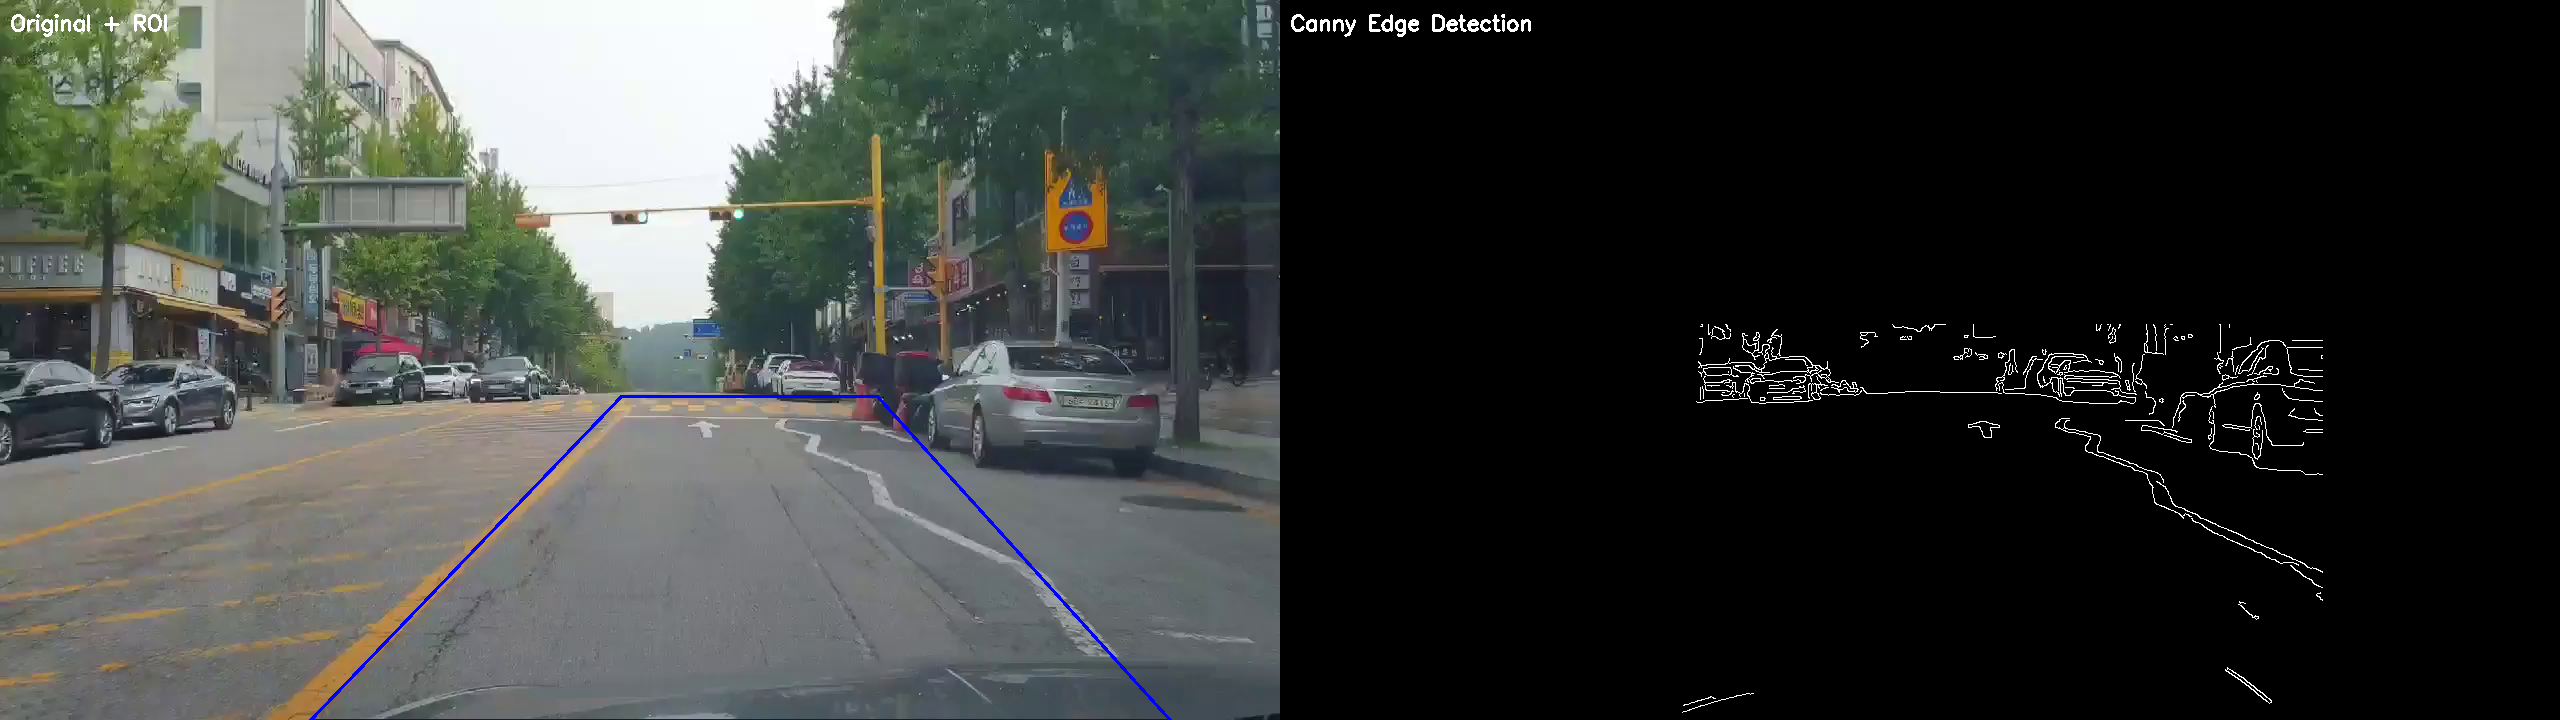

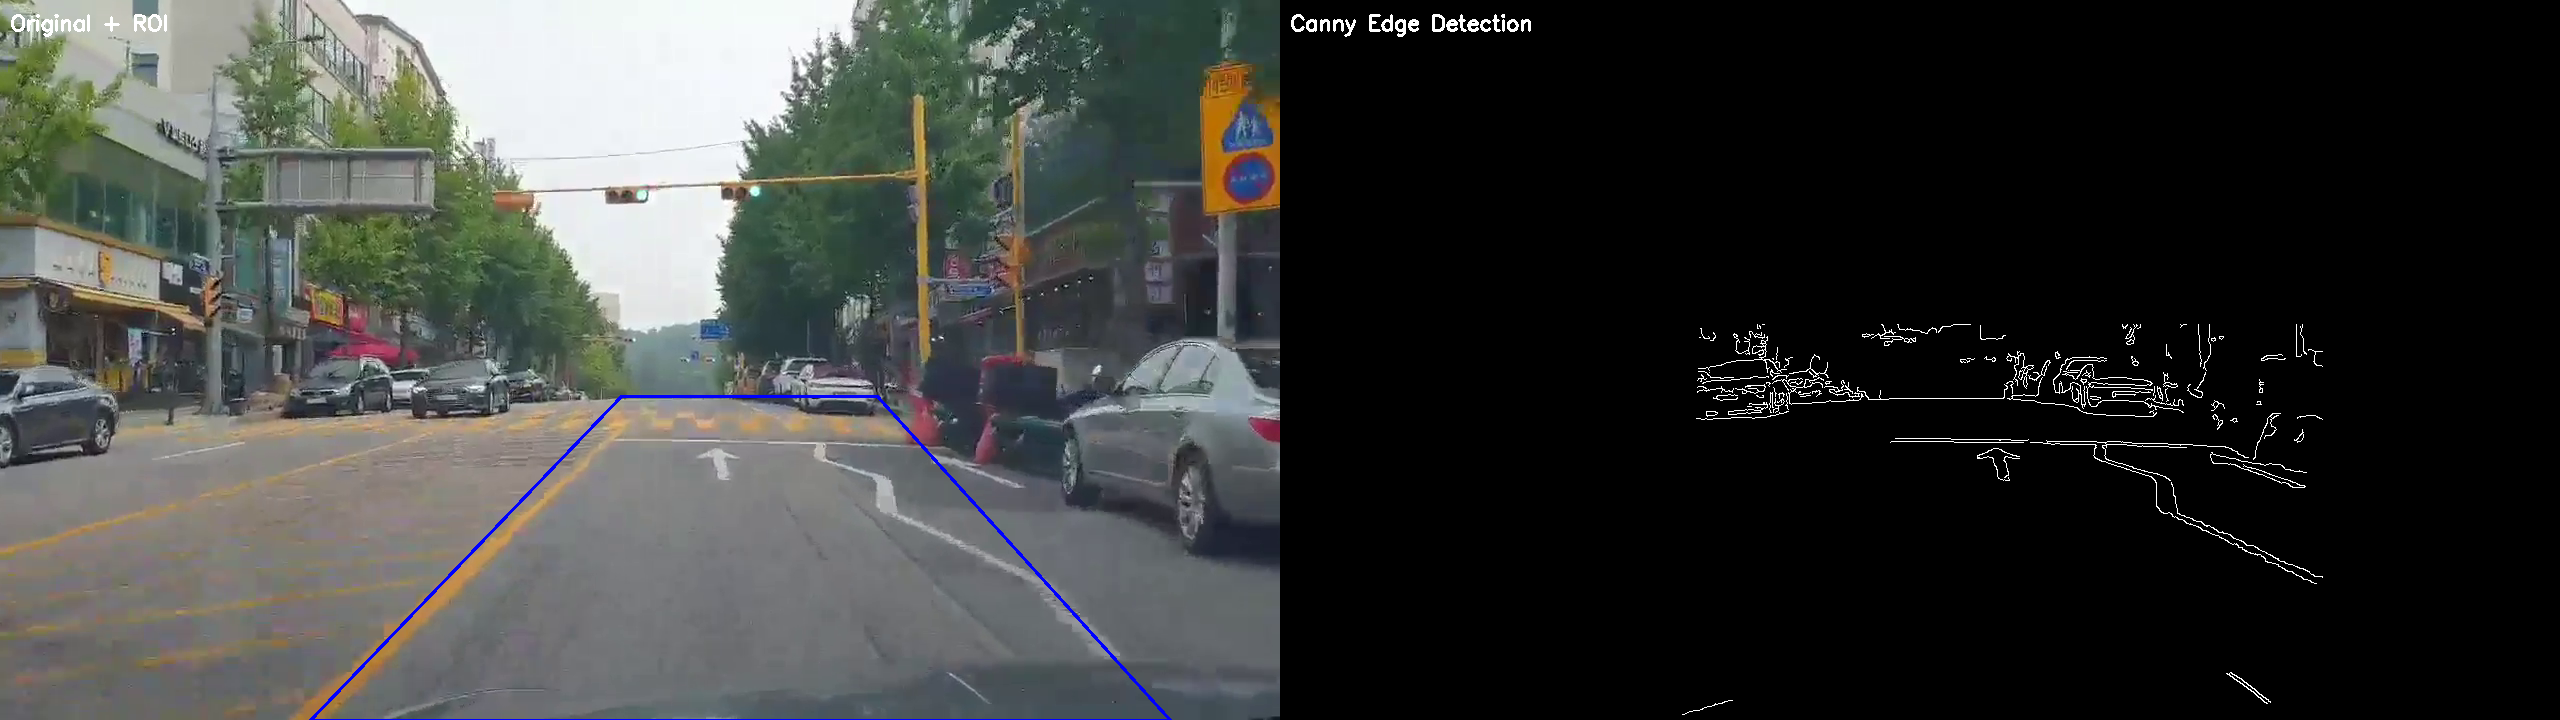

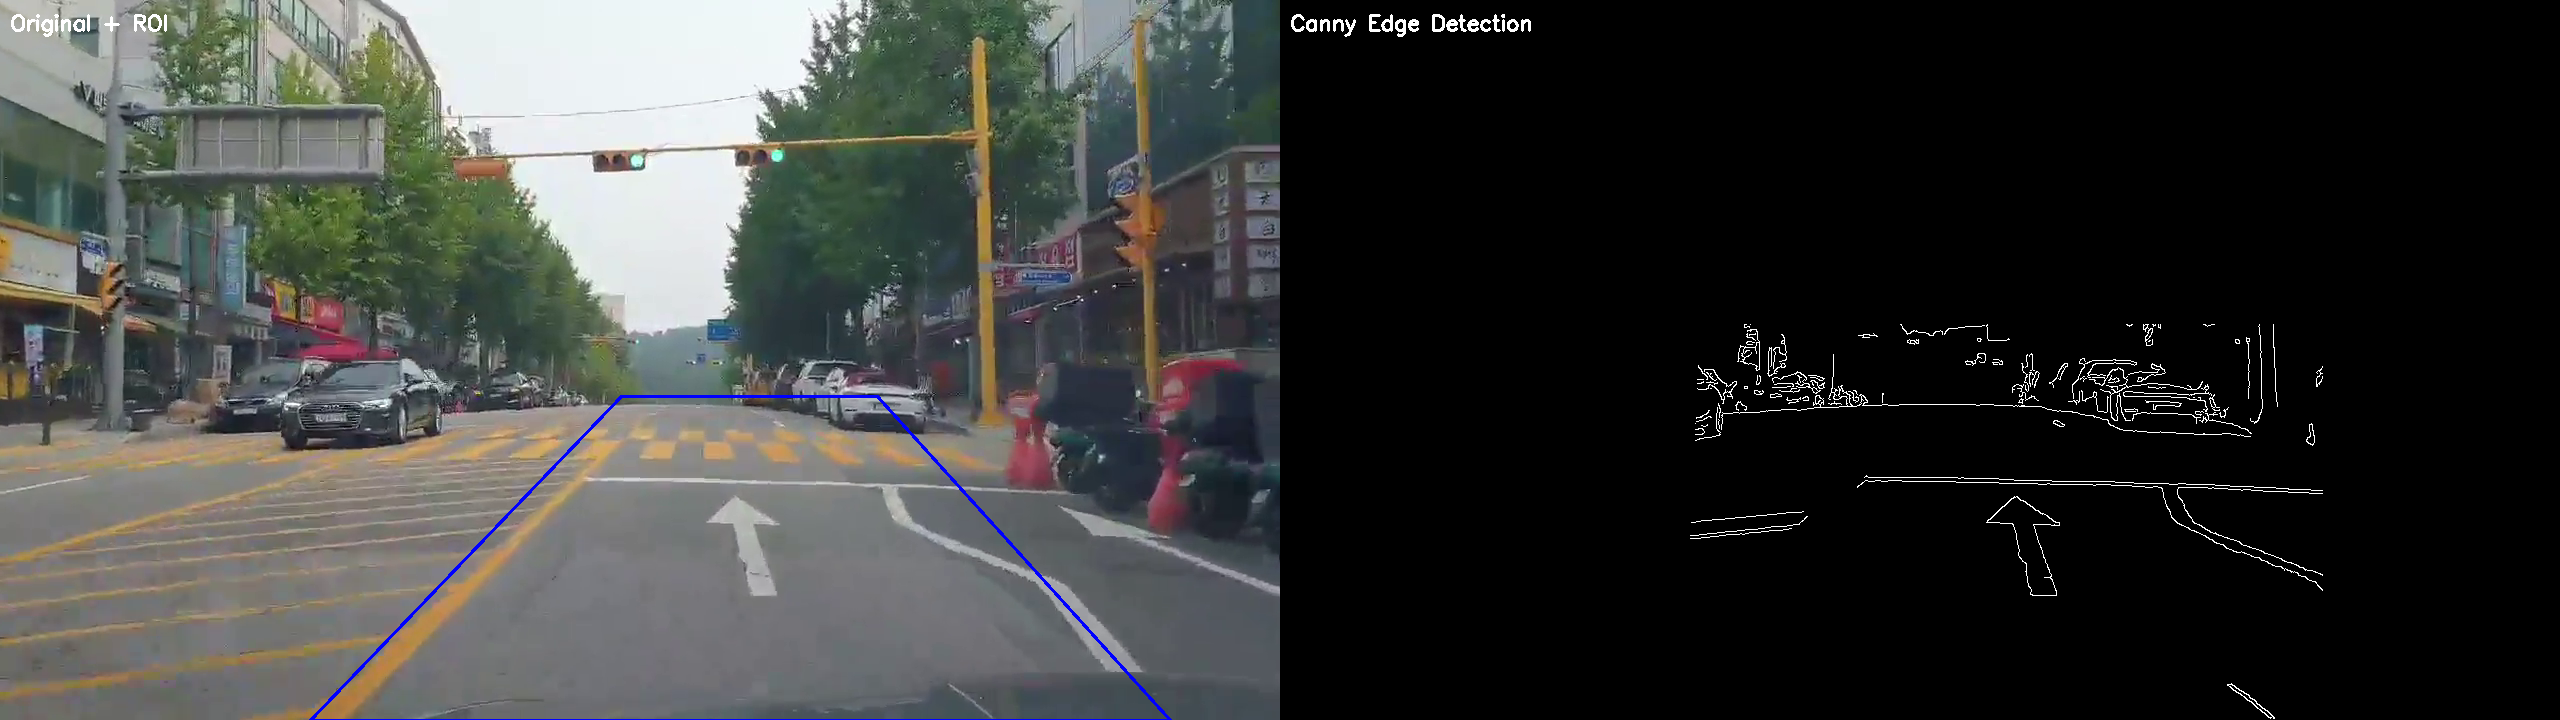

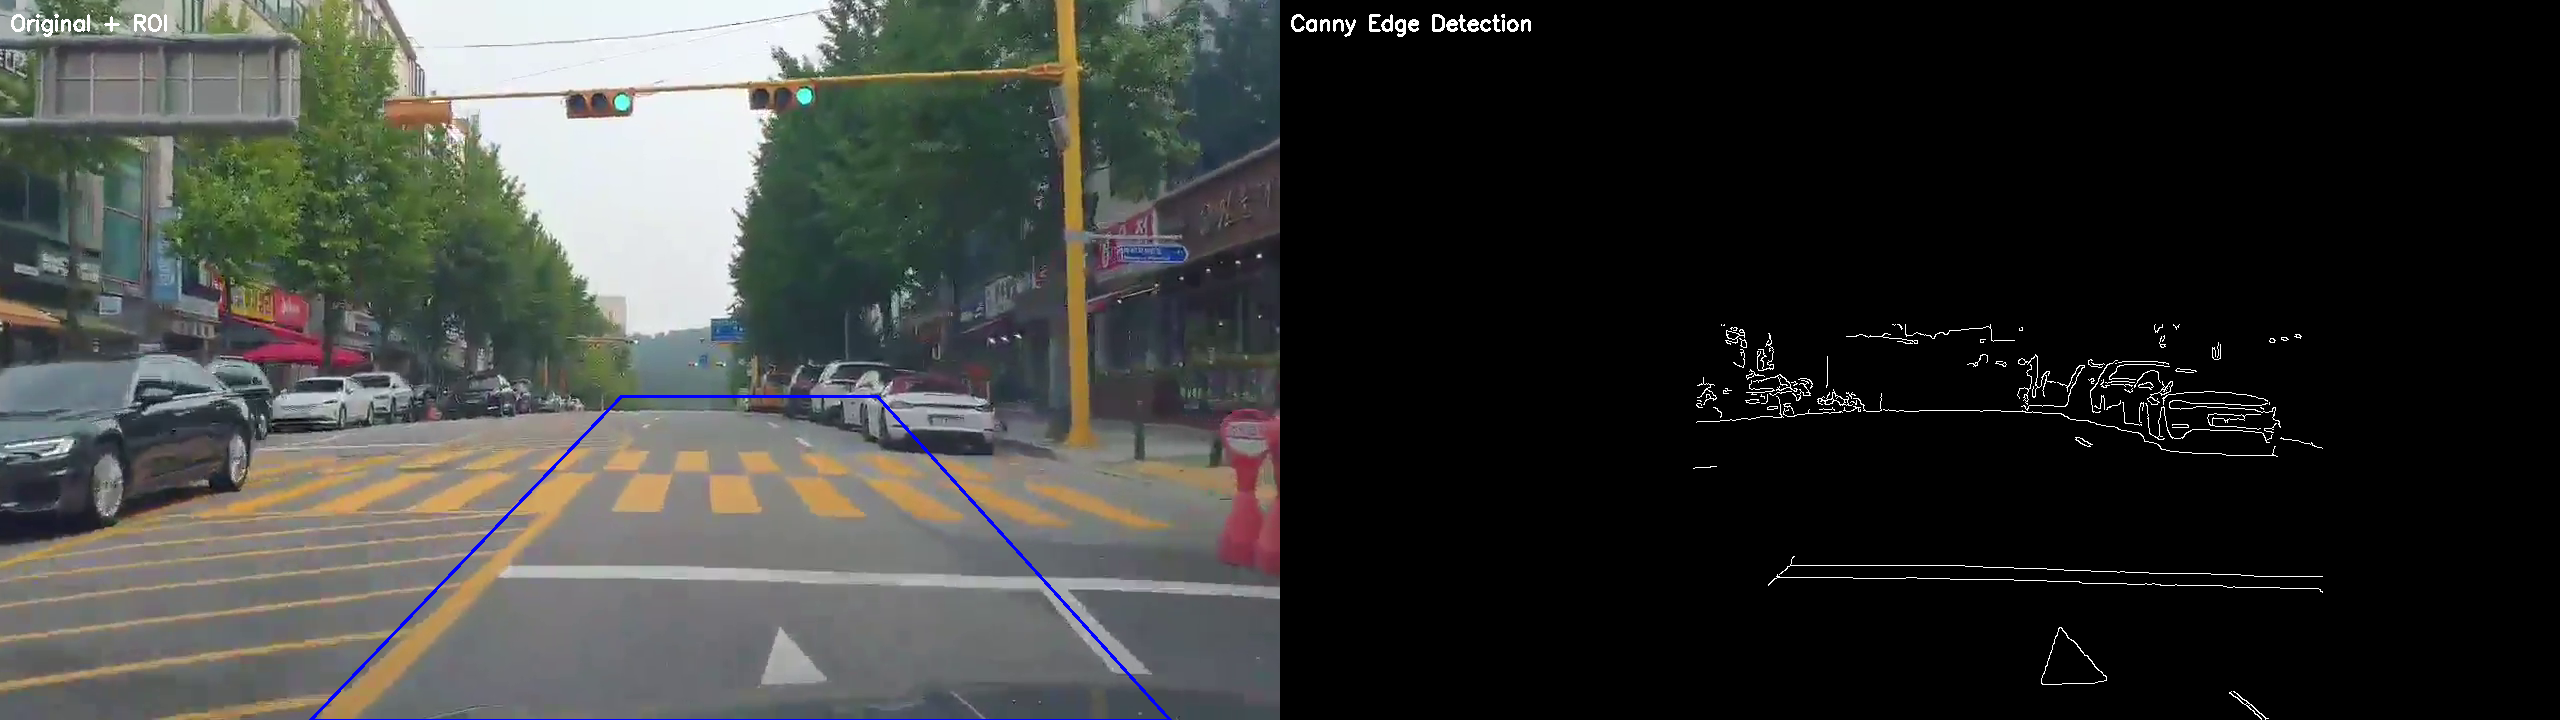

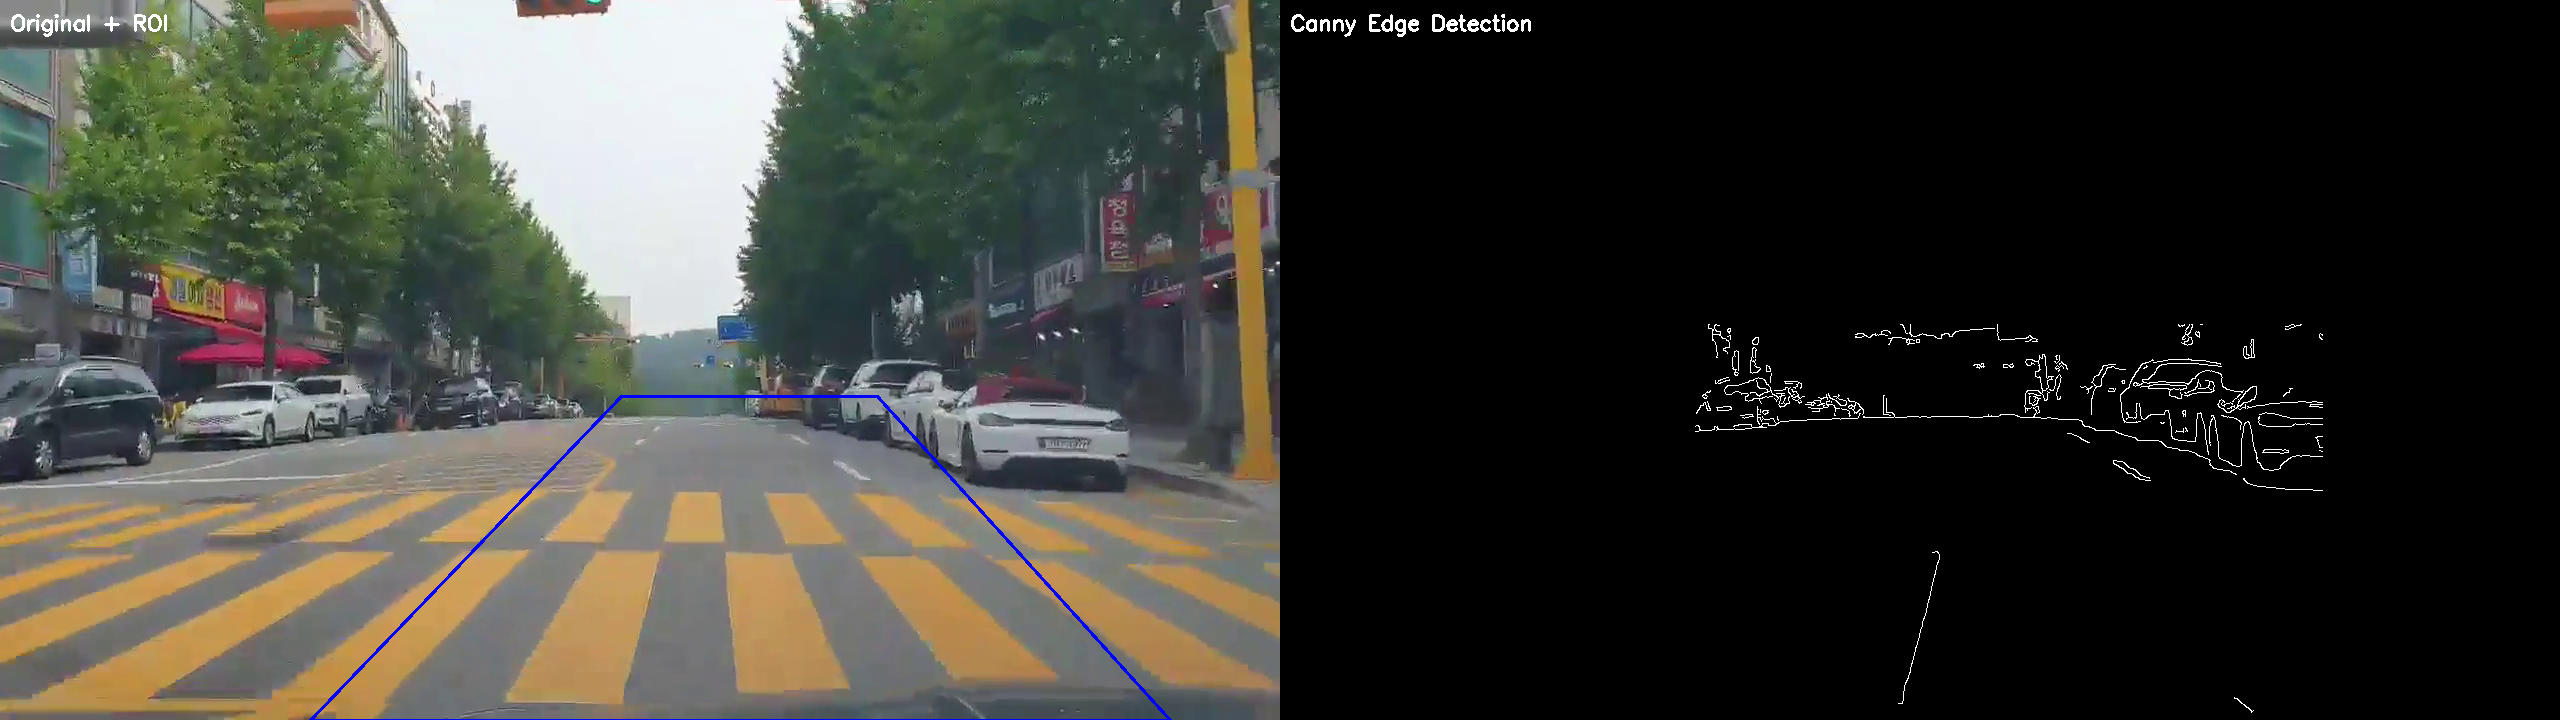

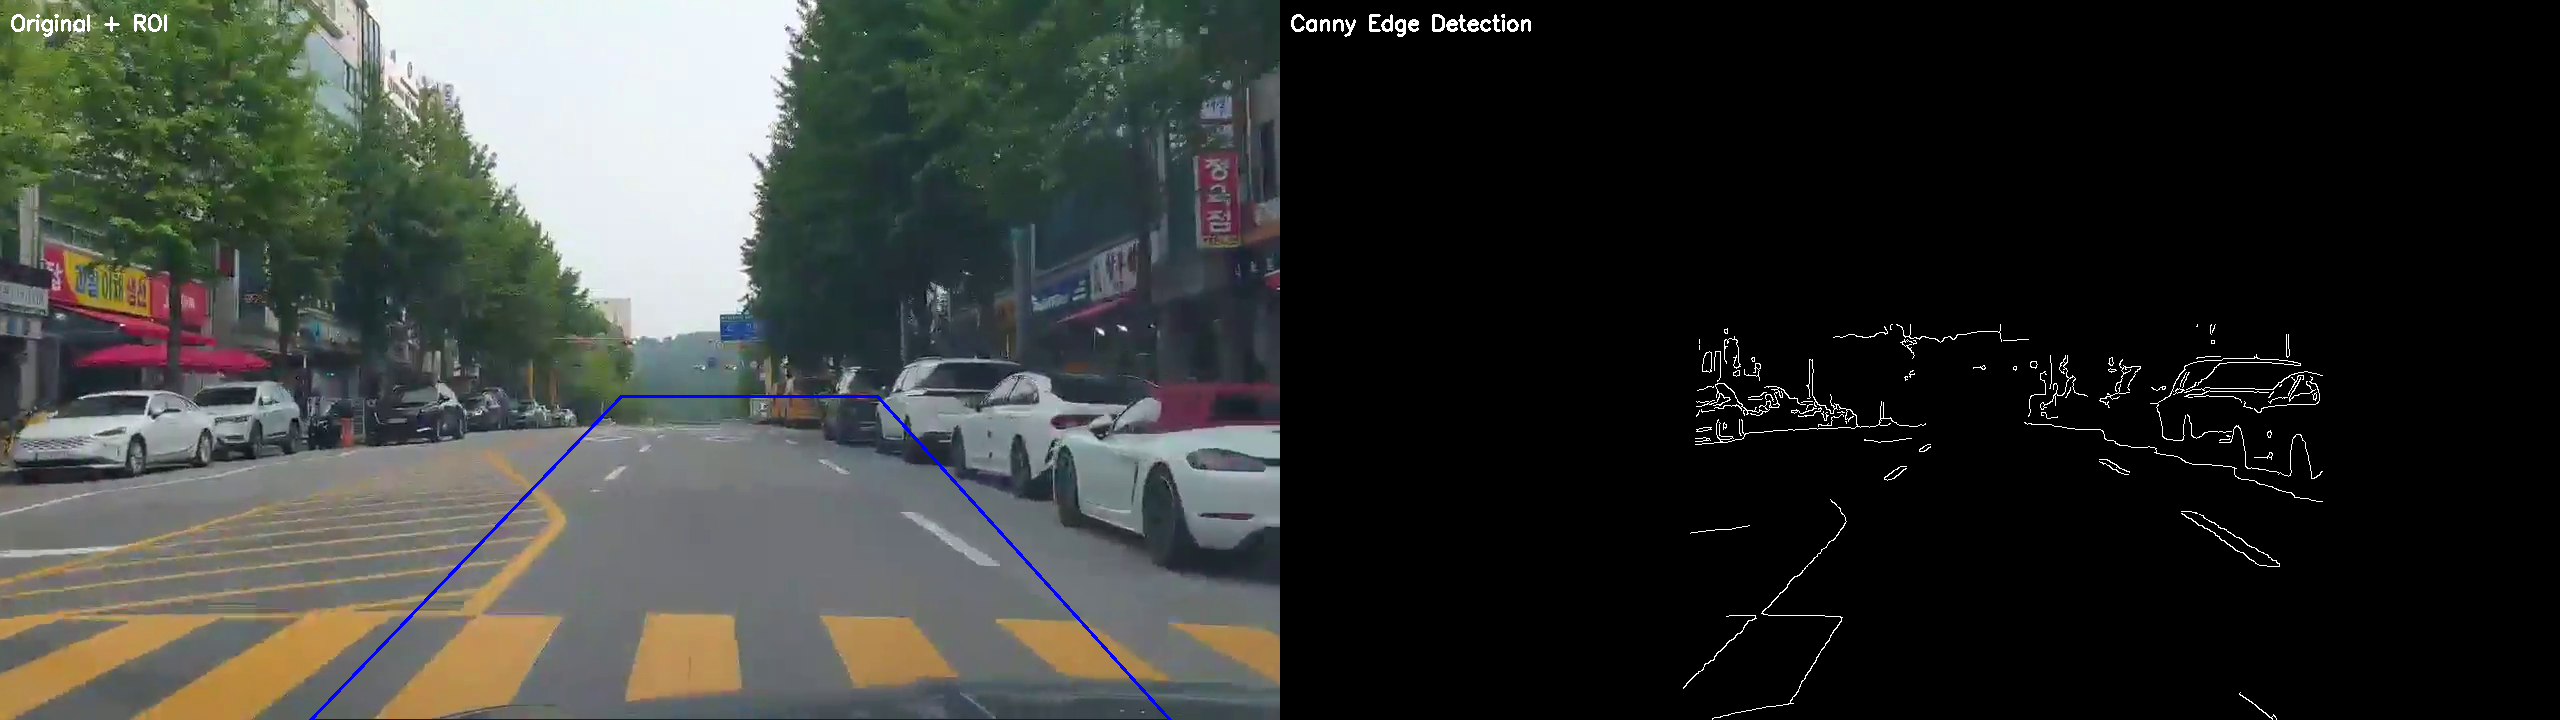

차선 검출 처리 완료!


In [61]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 동영상 파일 열기
cap = cv2.VideoCapture('/주행 영상.mp4')  # Colab에 업로드한 파일 경로

# 도로 형태에 맞춘 ROI
def create_lane_roi(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    # 사다리꼴: 아래는 넓고 위는 좁고, 세로는 깊게 (0.45까지)
    roi_points = np.array([
        [int(width * 2.2 / 7), height],               # 왼쪽 아래
        [int(width * 2.3 / 7), int(height * 0.45)],   # 왼쪽 위 (좁게, 높게)
        [int(width * 5.7 / 7), int(height * 0.45)],   # 오른쪽 위
        [int(width * 5.7 / 7), height]                # 오른쪽 아래
    ], np.int32)

    cv2.fillPoly(mask, [roi_points], 255)
    return mask

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 그레이스케일 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    # ROI 마스킹
    roi_mask = create_lane_roi(frame)
    masked_edges = cv2.bitwise_and(edges, roi_mask)

    # 시각화용 프레임
    result_frame = frame.copy()
    roi_points = np.array([
        [int(frame.shape[1] * 1.7 / 7), frame.shape[0]],
        [int(frame.shape[1] * 3.4 / 7), int(frame.shape[0] * 0.55)],
        [int(frame.shape[1] * 4.8 / 7), int(frame.shape[0] * 0.55)],
        [int(frame.shape[1] * 6.4 / 7), frame.shape[0]]
    ], np.int32)
    cv2.polylines(result_frame, [roi_points], True, (255, 0, 0), 2)

    # 매 20프레임마다 출력
    if frame_count % 20 == 0:
        cv2.putText(result_frame, "Original + ROI", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        edge_display = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)
        cv2.putText(edge_display, "Canny Edge Detection", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        combined = np.hstack((result_frame, edge_display))
        cv2_imshow(combined)

    frame_count += 1
    if frame_count > 100:
        break

cap.release()
print("차선 검출 처리 완료!")